# CD7 Dimensionality reduction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from ehv.masking import plot_scip_segmentation
from ehv.core import plot_gate_czi
from sklearn.preprocessing import scale, StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from sklearn.pipeline import make_pipeline
import flowutils

In [4]:
data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/results/scip/202203211633/")

df = pq.read_table(data_dir / "features.parquet").to_pandas()

df = df.set_index(["meta_panel", "meta_replicate", "meta_P", "meta_id"])
df = df.loc["D"]
df = df.loc[numpy.load(data_dir / "neutrophils.npy", allow_pickle=True)]
df = df.sort_index()

In [5]:
df.shape

(25427, 1494)

In [6]:
pca = PCA().fit_transform(scale(df.filter(regex="feat.*(Bright|Oblique|PGC)")))

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


<AxesSubplot:>

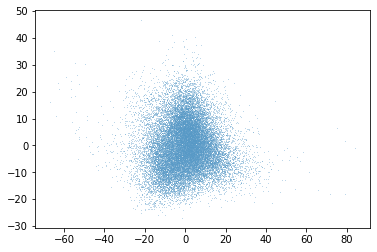

In [7]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], s=0.5, alpha=0.8, edgecolors="none")

# UMAP

In [8]:
%%time
umap_ = umap.UMAP(n_jobs=10).fit_transform(scale(df.filter(regex="feat.*(Bright|Oblique|PGC)")))

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


CPU times: user 4min 24s, sys: 1.51 s, total: 4min 25s
Wall time: 30.1 s


<AxesSubplot:>

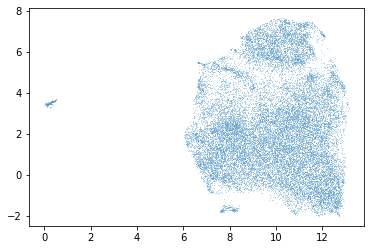

In [9]:
seaborn.scatterplot(x=umap_[:, 0], y=umap_[:, 1], s=0.5, alpha=0.8, edgecolors="none")

<AxesSubplot:>

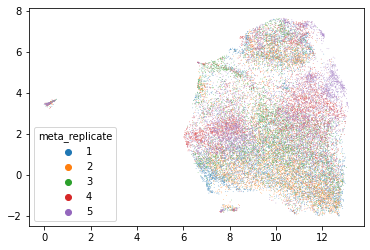

In [14]:
seaborn.scatterplot(x=umap_[:, 0], y=umap_[:, 1], s=0.5, hue=df.reset_index()["meta_replicate"], palette="tab10", alpha=0.8, edgecolors="none")

In [17]:
sel1 = umap_[:, 0] <= 2

In [16]:
from sklearn.feature_selection import mutual_info_classif

In [18]:
mi = mutual_info_classif(scale(df.filter(regex="feat.*(Bright|Oblique|PGC)")), sel1, n_neighbors=10)

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [21]:
mi = pandas.Series(mi, index=df.filter(regex="feat.*(Bright|Oblique|PGC)").columns).sort_values()

In [30]:
mi.iloc[-40:]

feat_inertia_tensor_eigvals-0_Bright    0.031823
feat_convex_area_Bright                 0.034342
feat_convex_area_Oblique                0.034349
feat_convex_area_PGC                    0.034358
feat_filled_area_PGC                    0.035037
feat_filled_area_Bright                 0.035043
feat_moments_central-0-0_Oblique        0.035062
feat_area_PGC                           0.035065
feat_moments_central-0-0_PGC            0.035080
feat_area_Bright                        0.035091
feat_area_Oblique                       0.035093
feat_moments-0-0_Bright                 0.035098
feat_filled_area_Oblique                0.035109
feat_moments-0-0_Oblique                0.035115
feat_moments-0-0_PGC                    0.035122
feat_moments_central-0-0_Bright         0.035145
feat_extent_Bright                      0.035943
feat_extent_PGC                         0.035947
feat_extent_Oblique                     0.035950
feat_moments_hu-0_PGC                   0.047111
feat_moments_hu-0_Br

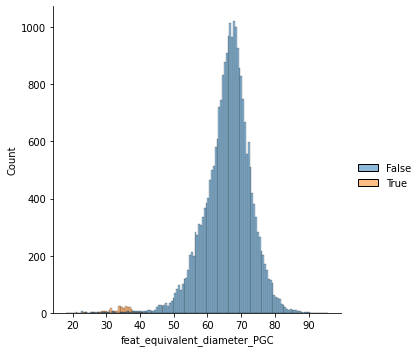

In [26]:
seaborn.displot(data=df, x="feat_equivalent_diameter_PGC", hue=sel1)

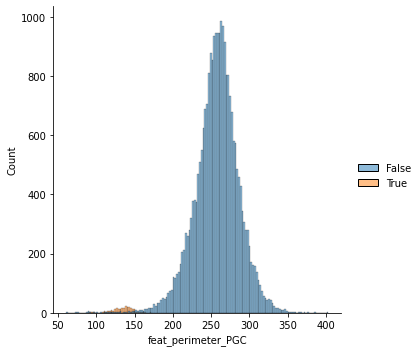

In [28]:
seaborn.displot(data=df, x="feat_perimeter_PGC", hue=sel1)

In [31]:
df = df[~sel1]
df.shape

(25155, 1494)

# UMAP after removal of small objects

In [89]:
%%time
umap2_ = umap.UMAP(n_jobs=10, min_dist=0, n_neighbors=30).fit_transform(scale(df.filter(regex="feat.*(Bright|Oblique|PGC)")))

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


CPU times: user 4min 55s, sys: 2.08 s, total: 4min 57s
Wall time: 25.1 s


<AxesSubplot:>

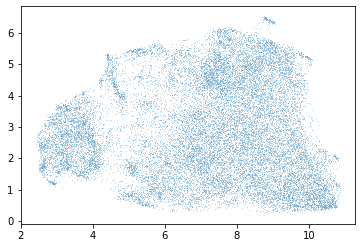

In [90]:
seaborn.scatterplot(x=umap2_[:, 0], y=umap2_[:, 1], s=0.5, alpha=0.8, edgecolors="none")

## Structure 1

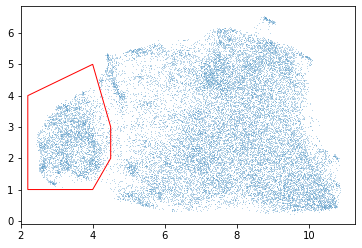

In [94]:
from matplotlib.path import Path as mPath
from matplotlib.patches import Polygon

vertices = numpy.array([
    [4, 1],
    [4.5, 2],
    [4.5, 3],
    [4, 5],
    [2.2, 4],
    [2.2, 1]
])
p = Polygon(vertices, facecolor = 'none', edgecolor="red")
ax = seaborn.scatterplot(x=umap2_[:, 0], y=umap2_[:, 1], s=0.5, alpha=0.8, edgecolors="none")
ax.add_patch(p)

In [95]:
sel1 = mPath(vertices).contains_points(umap2_)

In [96]:
%%time
mi = mutual_info_classif(scale(df.filter(regex="feat.*DAPI")), sel1, n_neighbors=10)

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


CPU times: user 24 s, sys: 38.8 ms, total: 24 s
Wall time: 24.1 s


In [97]:
mi = pandas.Series(mi, index=df.filter(regex="feat.*DAPI").columns).sort_values()

In [98]:
mi.iloc[-40:]

feat_filled_area_DAPI                      0.079892
feat_moments-2-0_DAPI                      0.081016
feat_moments-0-2_DAPI                      0.081111
feat_combined_bgcorr_sum_DAPI              0.081148
feat_combined_sum_DAPI                     0.081176
feat_moments_central-2-1_DAPI              0.081398
feat_moments_central-1-2_DAPI              0.081656
feat_moments-0-3_DAPI                      0.081667
feat_moments-3-0_DAPI                      0.081892
feat_moments-1-0_DAPI                      0.082283
feat_moments-0-1_DAPI                      0.083122
feat_glcm_mean_correlation_3_DAPI          0.085494
feat_moments-3-1_DAPI                      0.088351
feat_moments-1-3_DAPI                      0.089432
feat_moments-1-2_DAPI                      0.090000
feat_moments_central-2-3_DAPI              0.090987
feat_moments-2-1_DAPI                      0.091304
feat_moments_central-3-2_DAPI              0.091346
feat_skewness_DAPI                         0.092171
feat_bgcorr_

<AxesSubplot:>

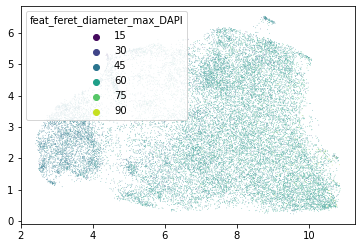

In [99]:
seaborn.scatterplot(x=umap2_[:, 0], y=umap2_[:, 1], hue=df["feat_feret_diameter_max_DAPI"], palette="viridis", s=0.5, alpha=0.8, edgecolors="none")

<AxesSubplot:>

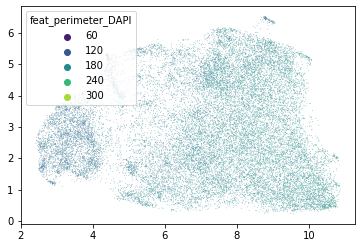

In [100]:
seaborn.scatterplot(x=umap2_[:, 0], y=umap2_[:, 1], hue=df["feat_perimeter_DAPI"], palette="viridis", s=0.5, alpha=0.8, edgecolors="none")

0 P1-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P10-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P10-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P10-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P11-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P11-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P12-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P14-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P15-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P16-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P16-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P17-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P17-D4 /data/gent/vo/000/gv

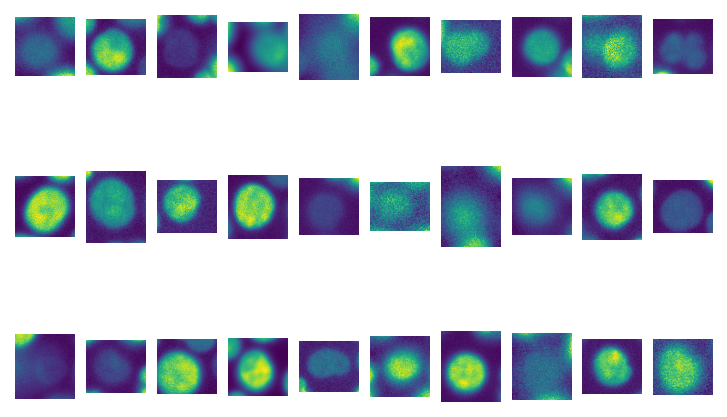

In [76]:
plot_gate_czi(sel1, df, maxn=30, channel=0)

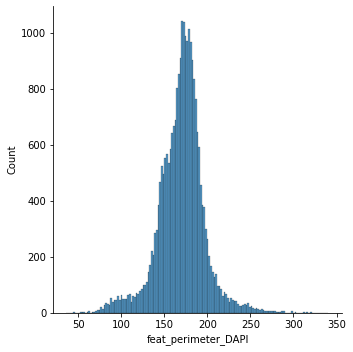

In [101]:
seaborn.displot(data=df, x="feat_perimeter_DAPI")

0 P1-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P10-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P10-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P12-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P13-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P13-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P13-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P14-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P16-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P17-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P17-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P17-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P18-D4 /data/gent/vo/000/gv

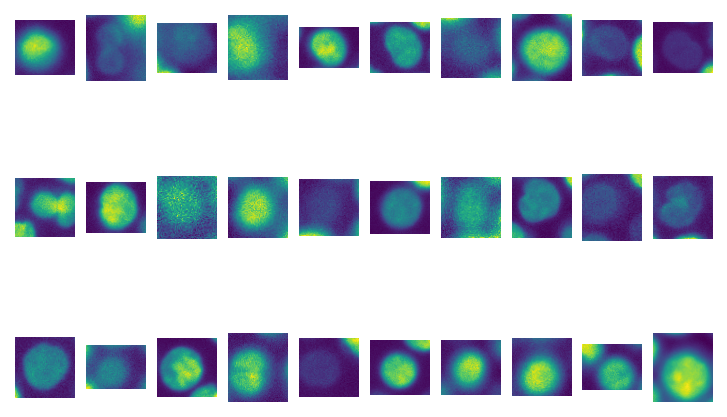

In [78]:
sel2 = df["feat_perimeter_DAPI"] > 300
plot_gate_czi(sel1, df, maxn=30, channel=0)

In [80]:
areadiff = df["feat_convex_area_DAPI"] - df["feat_area_DAPI"]

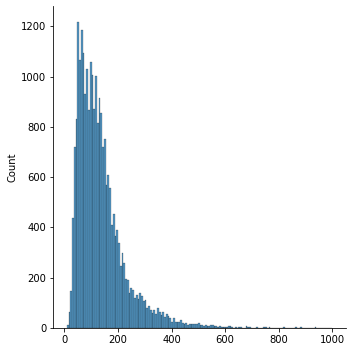

In [81]:
seaborn.displot(areadiff)

0 P10-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P14-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P14-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P15-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P15-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P17-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P18-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P18-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P19-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P22-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P4-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P7-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P8-D3 /data/gent/vo/000/gvo0

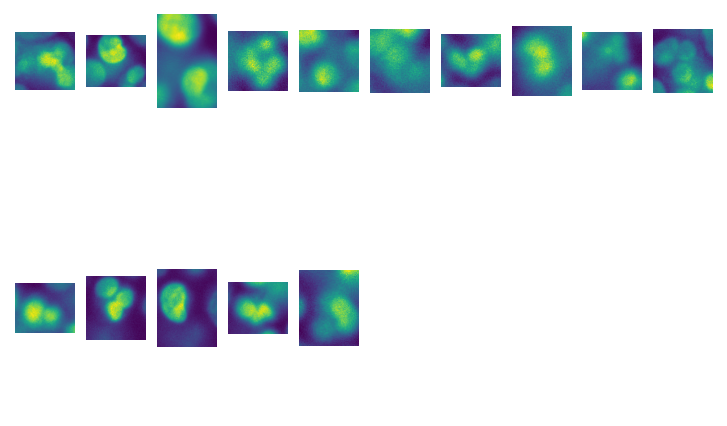

In [82]:
sel3 = areadiff > 800
plot_gate_czi(sel3, df)

<AxesSubplot:>

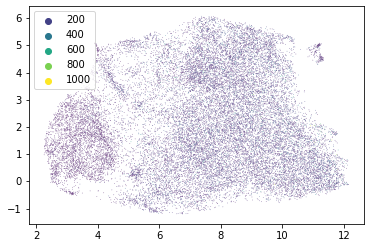

In [83]:
seaborn.scatterplot(x=umap2_[:, 0], y=umap2_[:, 1], hue=areadiff, palette="viridis", s=0.5, alpha=0.8, edgecolors="none")

## Structure 2

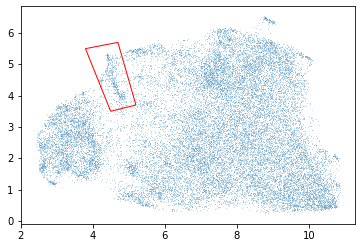

In [110]:
from matplotlib.path import Path as mPath
from matplotlib.patches import Polygon

vertices = numpy.array([
    [3.8,5.5],
    [4.7, 5.7],
    [5.2, 3.7],
    [4.5, 3.5]
])
p = Polygon(vertices, facecolor = 'none', edgecolor="red")
ax = seaborn.scatterplot(x=umap2_[:, 0], y=umap2_[:, 1], s=0.5, alpha=0.8, edgecolors="none")
ax.add_patch(p)

In [111]:
sel2 = mPath(vertices).contains_points(umap2_)

In [112]:
%%time
mi = mutual_info_classif(scale(df.filter(regex="feat.*DAPI")), sel2, n_neighbors=10)

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


CPU times: user 24 s, sys: 6.89 ms, total: 24 s
Wall time: 24.1 s


In [113]:
mi = pandas.Series(mi, index=df.filter(regex="feat.*DAPI").columns).sort_values()

In [114]:
mi.iloc[-40:]

feat_perimeter_crofton_DAPI                     0.011040
feat_feret_diameter_max_DAPI                    0.011081
feat_major_axis_length_DAPI                     0.011210
feat_perimeter_DAPI                             0.011255
feat_moments-3-0_DAPI                           0.011438
feat_inertia_tensor_eigvals-0_DAPI              0.011497
feat_moments-2-0_DAPI                           0.011865
feat_combined_glcm_mean_dissimilarity_3_DAPI    0.012192
feat_moments_central-2-0_DAPI                   0.012361
feat_moments-3-1_DAPI                           0.012369
feat_combined_sum_DAPI                          0.012389
feat_combined_bgcorr_sum_DAPI                   0.012406
feat_inertia_tensor-0-0_DAPI                    0.013338
feat_moments-2-1_DAPI                           0.013429
feat_minor_axis_length_DAPI                     0.013517
feat_moments-3-3_DAPI                           0.013636
feat_moments-3-2_DAPI                           0.013730
feat_inertia_tensor_eigvals-1_D

<AxesSubplot:>

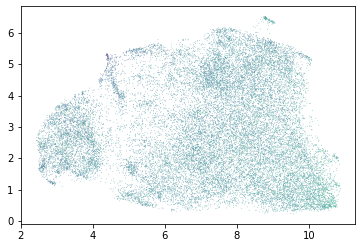

In [116]:
seaborn.scatterplot(x=umap2_[:, 0], y=umap2_[:, 1], hue=df["feat_combined_glcm_mean_homogeneity_5_DAPI"], palette="viridis", s=0.5, alpha=0.8, edgecolors="none", legend=None)

0 P1-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P1-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P10-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P11-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P11-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P11-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P12-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P12-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P12-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P13-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P14-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P14-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P15-D3 /data/gent/vo/000/gvo

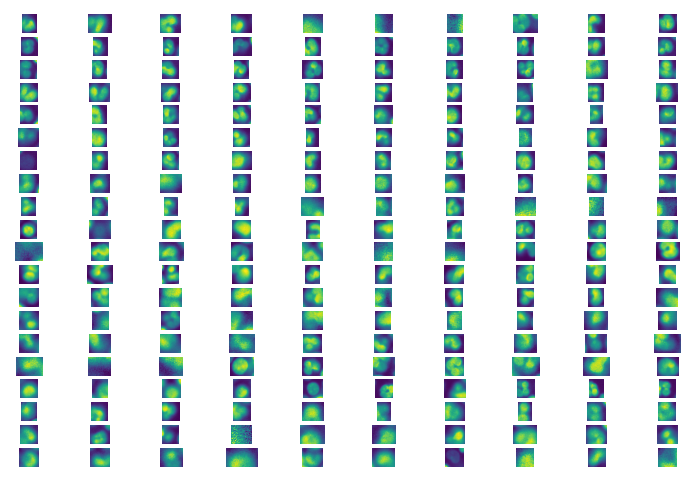

In [117]:
plot_gate_czi(sel2, df)

## Structure 3